In [1]:
import pandas as pd
import numpy as np
from pandas import read_excel
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from calendar import day_abbr, month_abbr, mdays
import datetime
#from datetime import datetime
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

#Author: Vatsala

In [2]:
plot_file_path="../plotImages/"

plot_data_path="../plotData/"

In [3]:
#****** Note: Data has been QC-ed

#read met Data to get the units of the different measurements
met_data = read_excel('../metData/ASSIST_EH_Biomet_30mins_Merged_20200605.xlsx', sheet_name='ASSIST_EH_Biomet_30mins_Merged', header=0)  #index_col=0, parse_dates=[0]    

In [4]:
print(met_data)

               TIMESTAMP_1    PPFD_1_1_1 SWin_1_1_1 SWout_1_1_1 LWin_1_1_1  \
0         yyyy-mm-dd HH:MM  umol+1m-2s-1     W+1m-2      W+1m-2     W+1m-2   
1      2018-12-21 08:30:00         7.745      1.736       1.436     343.55   
2      2018-12-21 09:00:00        18.115     7.6995      1.1595     353.75   
3      2018-12-21 09:30:00         21.28     7.6915       0.864     351.45   
4      2018-12-21 10:00:00        65.275     28.765      3.7425      350.4   
...                    ...           ...        ...         ...        ...   
25518  2020-06-04 23:00:00         0.002    -0.5485       0.497      333.4   
25519  2020-06-04 23:30:00         0.004     -0.548      0.4845      336.4   
25520  2020-06-05 00:00:00         0.004    -0.6595       0.378      339.2   
25521  2020-06-05 00:30:00         0.007     -0.422      0.3765      345.8   
25522  2020-06-05 01:00:00        0.0065     -0.609        0.36      344.7   

      LWout_1_1_1 Rnet_1_1_1  G_1_1_1  G_2_1_1 Ta_1_1_1  ... TD

In [5]:
metdata_unit = pd.DataFrame()

metdata_unit['metUnit'] = met_data.iloc[0,:]
metdata_unit

,metUnit
TIMESTAMP_1,yyyy-mm-dd HH:MM
PPFD_1_1_1,umol+1m-2s-1
SWin_1_1_1,W+1m-2
SWout_1_1_1,W+1m-2
LWin_1_1_1,W+1m-2
LWout_1_1_1,W+1m-2
Rnet_1_1_1,W+1m-2
G_1_1_1,W+1m-2
G_2_1_1,W+1m-2
Ta_1_1_1,C


In [6]:
met_data

,TIMESTAMP_1,PPFD_1_1_1,SWin_1_1_1,SWout_1_1_1,LWin_1_1_1,LWout_1_1_1,Rnet_1_1_1,G_1_1_1,G_2_1_1,Ta_1_1_1,...,TDT2_Ts_1_1_1,TDT3_Ts_1_1_1,TDT4_Ts_1_1_1,VWC_1_1_1,VWC_2_1_1,VWC_3_1_1,VWC_4_1_1,WaterLevel_1_1_1,SigStrength_1_1_1,AGC_1_1_1
0,yyyy-mm-dd HH:MM,umol+1m-2s-1,W+1m-2,W+1m-2,W+1m-2,W+1m-2,W+1m-2,W+1m-2,W+1m-2,C,...,C,C,C,%,%,%,%,mm,%,dim
1,2018-12-21 08:30:00,7.745,1.736,1.436,343.55,355.45,-11.6,17.2844,16.9636,10.81,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,94.5,-9999
2,2018-12-21 09:00:00,18.115,7.6995,1.1595,353.75,361.8,-1.51,12.0295,10.3424,10.515,...,7.25,8.2,8.85,18.4,26.85,26.7,33.2,-9999,100,-9999
3,2018-12-21 09:30:00,21.28,7.6915,0.864,351.45,360.6,-2.3225,8.07984,5.8823,10.375,...,7.35,8.2,8.65,18.4,26.95,26.25,33.2,-9999,100,-9999
4,2018-12-21 10:00:00,65.275,28.765,3.7425,350.4,360.85,14.5725,6.18701,4.13848,10.49,...,7.4,8.15,8.45,18.2,27.25,26.1,33.2,-9999,100,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25518,2020-06-04 23:00:00,0.002,-0.5485,0.497,333.4,365.2,-32.8455,-7.38646,-8.05636,10.48,...,14.4,14.3,13.6,8.15,14.6,12.3,14.2,-9999,100,-9999
25519,2020-06-04 23:30:00,0.004,-0.548,0.4845,336.4,364.7,-29.3325,-7.5716,-8.05554,10.455,...,14.4,14.25,13.55,8.15,14.6,12.3,14.2,-9999,100,-9999
25520,2020-06-05 00:00:00,0.004,-0.6595,0.378,339.2,366.55,-28.3875,-7.40327,-7.75931,10.545,...,14.35,14.15,13.45,8.3,14.6,12,14.25,-9999,100,-9999
25521,2020-06-05 00:30:00,0.007,-0.422,0.3765,345.8,367.8,-22.7985,-6.98852,-7.08234,10.685,...,14.3,14.1,13.4,8.3,14.6,12,14.3,-9999,100,-9999


In [7]:
#Drop the first row from the dataset
met_data.drop(met_data.index[0], inplace=True)  #with inplace=True, we do not need to reassign the statement to the dataframe

In [8]:
met_data

,TIMESTAMP_1,PPFD_1_1_1,SWin_1_1_1,SWout_1_1_1,LWin_1_1_1,LWout_1_1_1,Rnet_1_1_1,G_1_1_1,G_2_1_1,Ta_1_1_1,...,TDT2_Ts_1_1_1,TDT3_Ts_1_1_1,TDT4_Ts_1_1_1,VWC_1_1_1,VWC_2_1_1,VWC_3_1_1,VWC_4_1_1,WaterLevel_1_1_1,SigStrength_1_1_1,AGC_1_1_1
1,2018-12-21 08:30:00,7.745,1.736,1.436,343.55,355.45,-11.6,17.2844,16.9636,10.81,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,94.5,-9999
2,2018-12-21 09:00:00,18.115,7.6995,1.1595,353.75,361.8,-1.51,12.0295,10.3424,10.515,...,7.25,8.2,8.85,18.4,26.85,26.7,33.2,-9999,100,-9999
3,2018-12-21 09:30:00,21.28,7.6915,0.864,351.45,360.6,-2.3225,8.07984,5.8823,10.375,...,7.35,8.2,8.65,18.4,26.95,26.25,33.2,-9999,100,-9999
4,2018-12-21 10:00:00,65.275,28.765,3.7425,350.4,360.85,14.5725,6.18701,4.13848,10.49,...,7.4,8.15,8.45,18.2,27.25,26.1,33.2,-9999,100,-9999
5,2018-12-21 10:30:00,111.155,51.505,6.9765,349.05,361.7,31.8785,7.06924,5.48763,10.525,...,7.4,8.1,8.4,18.25,27.65,26.7,33.2,-9999,100,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25518,2020-06-04 23:00:00,0.002,-0.5485,0.497,333.4,365.2,-32.8455,-7.38646,-8.05636,10.48,...,14.4,14.3,13.6,8.15,14.6,12.3,14.2,-9999,100,-9999
25519,2020-06-04 23:30:00,0.004,-0.548,0.4845,336.4,364.7,-29.3325,-7.5716,-8.05554,10.455,...,14.4,14.25,13.55,8.15,14.6,12.3,14.2,-9999,100,-9999
25520,2020-06-05 00:00:00,0.004,-0.6595,0.378,339.2,366.55,-28.3875,-7.40327,-7.75931,10.545,...,14.35,14.15,13.45,8.3,14.6,12,14.25,-9999,100,-9999
25521,2020-06-05 00:30:00,0.007,-0.422,0.3765,345.8,367.8,-22.7985,-6.98852,-7.08234,10.685,...,14.3,14.1,13.4,8.3,14.6,12,14.3,-9999,100,-9999


In [9]:
#set the index of data to Timestamp
met_data.set_index('TIMESTAMP_1', inplace=True)
met_data

,PPFD_1_1_1,SWin_1_1_1,SWout_1_1_1,LWin_1_1_1,LWout_1_1_1,Rnet_1_1_1,G_1_1_1,G_2_1_1,Ta_1_1_1,RH_1_1_1,...,TDT2_Ts_1_1_1,TDT3_Ts_1_1_1,TDT4_Ts_1_1_1,VWC_1_1_1,VWC_2_1_1,VWC_3_1_1,VWC_4_1_1,WaterLevel_1_1_1,SigStrength_1_1_1,AGC_1_1_1
TIMESTAMP_1,,,,,,,,,,,,,,,,,,,,,
2018-12-21 08:30:00,7.745,1.736,1.436,343.55,355.45,-11.6,17.2844,16.9636,10.81,85.7,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,94.5,-9999
2018-12-21 09:00:00,18.115,7.6995,1.1595,353.75,361.8,-1.51,12.0295,10.3424,10.515,80.41,...,7.25,8.2,8.85,18.4,26.85,26.7,33.2,-9999,100,-9999
2018-12-21 09:30:00,21.28,7.6915,0.864,351.45,360.6,-2.3225,8.07984,5.8823,10.375,78.2,...,7.35,8.2,8.65,18.4,26.95,26.25,33.2,-9999,100,-9999
2018-12-21 10:00:00,65.275,28.765,3.7425,350.4,360.85,14.5725,6.18701,4.13848,10.49,74.77,...,7.4,8.15,8.45,18.2,27.25,26.1,33.2,-9999,100,-9999
2018-12-21 10:30:00,111.155,51.505,6.9765,349.05,361.7,31.8785,7.06924,5.48763,10.525,74.585,...,7.4,8.1,8.4,18.25,27.65,26.7,33.2,-9999,100,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-04 23:00:00,0.002,-0.5485,0.497,333.4,365.2,-32.8455,-7.38646,-8.05636,10.48,85.75,...,14.4,14.3,13.6,8.15,14.6,12.3,14.2,-9999,100,-9999
2020-06-04 23:30:00,0.004,-0.548,0.4845,336.4,364.7,-29.3325,-7.5716,-8.05554,10.455,87.9,...,14.4,14.25,13.55,8.15,14.6,12.3,14.2,-9999,100,-9999
2020-06-05 00:00:00,0.004,-0.6595,0.378,339.2,366.55,-28.3875,-7.40327,-7.75931,10.545,89.35,...,14.35,14.15,13.45,8.3,14.6,12,14.25,-9999,100,-9999


In [10]:
#Filter the dataframe to consider only a date range - applicable to the plots

#query = pd.Period('2009-12-28/2010-01-03', 'W-SUN')
#df.truncate(query.start_time, query.end_time)
#df[(df.index >= query.start_time) & (df.index <= query.end_time)]

met_data = met_data[(met_data.index >= '2019-03-26 17:26:00') & (met_data.index <= '2019-06-30 02:17:00')]
met_data

,PPFD_1_1_1,SWin_1_1_1,SWout_1_1_1,LWin_1_1_1,LWout_1_1_1,Rnet_1_1_1,G_1_1_1,G_2_1_1,Ta_1_1_1,RH_1_1_1,...,TDT2_Ts_1_1_1,TDT3_Ts_1_1_1,TDT4_Ts_1_1_1,VWC_1_1_1,VWC_2_1_1,VWC_3_1_1,VWC_4_1_1,WaterLevel_1_1_1,SigStrength_1_1_1,AGC_1_1_1
TIMESTAMP_1,,,,,,,,,,,,,,,,,,,,,
2019-03-26 17:30:00,277.5,146.15,33.14,267.1,366.25,13.86,1.18508,2.85365,11.85,54.435,...,10.15,12.05,13.6,18.6,27.75,30.25,36.05,-9999,100,-9999
2019-03-26 18:00:00,124.15,67.9,13.15,266.45,357.3,-36.1,-6.40419,-9.29737,11.21,57.315,...,10.25,11.8,12.55,18.6,27.7,30.35,35.95,-9999,100,-9999
2019-03-26 18:30:00,30.33,9.8225,1.458,280.85,341.65,-52.4355,-14.4412,-18.8931,9.785,63.445,...,10.3,11.4,11.5,18.6,27.75,30.45,35.9,-9999,100,-9999
2019-03-26 19:00:00,1.9145,-0.312,-0.069,315.65,345.15,-29.743,-17.1809,-20.9032,8.745,69.08,...,10.3,10.95,10.7,18.6,27.8,30.35,35.85,-9999,100,-9999
2019-03-26 19:30:00,0.0145,-1.2475,-0.3645,317.05,345.2,-29.033,-16.1875,-19.3229,8.53,71.18,...,10.25,10.55,10.2,18.6,27.75,30.35,35.8,-9999,100,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 00:00:00,0.0045,-2.61,0.381,322.45,394.5,-75.041,-24.2677,-15.6408,16.06,91.15,...,19.35,19.95,19.45,12.85,19.3,20.35,24.9,-9999,100,-9999
2019-06-30 00:30:00,0.004,-2.604,0.5075,314.7,391.65,-80.0615,-25.9029,-16.4602,15.565,90.85,...,19.25,19.65,19.1,12.8,19.3,20.2,24.9,-9999,100,-9999
2019-06-30 01:00:00,0.0045,-3.0015,0.454,304.9,387.85,-86.4055,-27.7037,-17.3981,15.075,90.5,...,19.15,19.4,18.75,12.8,19.25,20.2,24.85,-9999,100,-9999


In [11]:
metdata_unit

,metUnit
TIMESTAMP_1,yyyy-mm-dd HH:MM
PPFD_1_1_1,umol+1m-2s-1
SWin_1_1_1,W+1m-2
SWout_1_1_1,W+1m-2
LWin_1_1_1,W+1m-2
LWout_1_1_1,W+1m-2
Rnet_1_1_1,W+1m-2
G_1_1_1,W+1m-2
G_2_1_1,W+1m-2
Ta_1_1_1,C


In [12]:
#How to get data at one particular index value
print(metdata_unit.at['PPFD_1_1_1', 'metUnit'])

umol+1m-2s-1


In [13]:
#Plot the met data   - Soil Parameters (STP)  X LABELS NOT DISPLAYED APPROPRIATELY
#plt.rcParams["figure.figsize"] = (20, 15)
#fig, axs = plt.subplots(2, 2)
#fig.suptitle('Met Data - Soil Parameters (STP)', color = 'green')
#fig.tight_layout(pad=10.0)

##Find the unit of the particular plot
#unit = metdata_unit.at['STP_TSoil_2_1_1_1', 'metUnit']
#axs[0, 0].plot(met_data.index, met_data['STP_TSoil_2_1_1_1'], color = 'green')  #, edgecolor = 'darkblue'
#axs[0, 0].set_title('STP_TSoil_2_1_1_1'+' in ('+unit+')', color = 'green')
#axs[0, 0].set_xticklabels(met_data.index, rotation=30, ha='right', color = 'green')

#unit = metdata_unit.at['STP_TSoil5_1_1_1', 'metUnit']
#axs[0, 1].plot(met_data.index, met_data['STP_TSoil5_1_1_1'], color = '#3333FF')  #, edgecolor = 'darkblue'
#axs[0, 1].set_title('STP_TSoil5_1_1_1'+' in ('+unit+')', color = '#3333FF')
#axs[0, 1].set_xticklabels(met_data.index, rotation=30, ha='right', color = '#3333FF')

#unit = metdata_unit.at['STP_TSoil10_1_1_1', 'metUnit']
#axs[1, 0].plot(met_data.index, met_data['STP_TSoil10_1_1_1'], color = '#9933FF')  #, edgecolor = 'darkblue'
#axs[1, 0].set_title('STP_TSoil10_1_1_1'+' in ('+unit+')', color = '#9933FF')
#axs[1, 0].set_xticklabels(met_data.index, rotation=30, ha='right', color = '#9933FF')

#unit = metdata_unit.at['STP_TSoil50_1_1_1', 'metUnit']
#axs[1, 1].plot(met_data.index, met_data['STP_TSoil50_1_1_1'], color = '#FF3399')  #, edgecolor = 'darkblue'
#axs[1, 1].set_title('STP_TSoil50_1_1_1'+' in ('+unit+')', color = '#FF3399')
#axs[1, 1].set_xticklabels(met_data.index, rotation=30, ha='right', color = '#FF3399')

##Save boxplot as a file
##output file name
#output_file_name = "Plot1/gasflux_MetData_SoilParameters_STP.png" 
#plot_file_name = plot_file_path + output_file_name

## save as png
#plt.savefig(plot_file_name, dpi=50, bbox_inches='tight')

#plt.show()

In [14]:
met_data

,PPFD_1_1_1,SWin_1_1_1,SWout_1_1_1,LWin_1_1_1,LWout_1_1_1,Rnet_1_1_1,G_1_1_1,G_2_1_1,Ta_1_1_1,RH_1_1_1,...,TDT2_Ts_1_1_1,TDT3_Ts_1_1_1,TDT4_Ts_1_1_1,VWC_1_1_1,VWC_2_1_1,VWC_3_1_1,VWC_4_1_1,WaterLevel_1_1_1,SigStrength_1_1_1,AGC_1_1_1
TIMESTAMP_1,,,,,,,,,,,,,,,,,,,,,
2019-03-26 17:30:00,277.5,146.15,33.14,267.1,366.25,13.86,1.18508,2.85365,11.85,54.435,...,10.15,12.05,13.6,18.6,27.75,30.25,36.05,-9999,100,-9999
2019-03-26 18:00:00,124.15,67.9,13.15,266.45,357.3,-36.1,-6.40419,-9.29737,11.21,57.315,...,10.25,11.8,12.55,18.6,27.7,30.35,35.95,-9999,100,-9999
2019-03-26 18:30:00,30.33,9.8225,1.458,280.85,341.65,-52.4355,-14.4412,-18.8931,9.785,63.445,...,10.3,11.4,11.5,18.6,27.75,30.45,35.9,-9999,100,-9999
2019-03-26 19:00:00,1.9145,-0.312,-0.069,315.65,345.15,-29.743,-17.1809,-20.9032,8.745,69.08,...,10.3,10.95,10.7,18.6,27.8,30.35,35.85,-9999,100,-9999
2019-03-26 19:30:00,0.0145,-1.2475,-0.3645,317.05,345.2,-29.033,-16.1875,-19.3229,8.53,71.18,...,10.25,10.55,10.2,18.6,27.75,30.35,35.8,-9999,100,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 00:00:00,0.0045,-2.61,0.381,322.45,394.5,-75.041,-24.2677,-15.6408,16.06,91.15,...,19.35,19.95,19.45,12.85,19.3,20.35,24.9,-9999,100,-9999
2019-06-30 00:30:00,0.004,-2.604,0.5075,314.7,391.65,-80.0615,-25.9029,-16.4602,15.565,90.85,...,19.25,19.65,19.1,12.8,19.3,20.2,24.9,-9999,100,-9999
2019-06-30 01:00:00,0.0045,-3.0015,0.454,304.9,387.85,-86.4055,-27.7037,-17.3981,15.075,90.5,...,19.15,19.4,18.75,12.8,19.25,20.2,24.85,-9999,100,-9999


In [15]:
print(met_data['Ta_1_1_1'].max())

32.485


In [16]:
#from datetime import datetime, timedelta

x = datetime.datetime(2020, 5, 17, 16, 36) 


def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +datetime.timedelta(hours=t.minute//30))

print(x)
print(hour_rounder(x))


2020-05-17 16:36:00
2020-05-17 17:00:00


In [17]:
#from datetime import datetime, timedelta

x = datetime.datetime(2020, 5, 17, 16, 36) 


def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +datetime.timedelta(minutes=15*(t.minute // 15)))

print(x)
print(hour_rounder(x))


2020-05-17 16:36:00
2020-05-17 16:30:00


In [18]:
#test round function from dt

met_data1 = met_data.copy()
met_data1['TIMESTAMP_1_value'] = met_data1.index

#round the timestamp value to nearest quarter
#met_data1['TIMESTAMP_1_rounded'] = met_data1['TIMESTAMP_1_value'].dt.round('15min')

#round the timestamp value to nearest half hour
met_data1['TIMESTAMP_1_rounded'] = met_data1['TIMESTAMP_1_value'].dt.round('30min')

#Drop the column Timestamp - the rounded Timestamp value will be used for plotting
#met_data1.drop('TIMESTAMP_1_value', axis=1, inplace=True)

met_data1

,PPFD_1_1_1,SWin_1_1_1,SWout_1_1_1,LWin_1_1_1,LWout_1_1_1,Rnet_1_1_1,G_1_1_1,G_2_1_1,Ta_1_1_1,RH_1_1_1,...,TDT4_Ts_1_1_1,VWC_1_1_1,VWC_2_1_1,VWC_3_1_1,VWC_4_1_1,WaterLevel_1_1_1,SigStrength_1_1_1,AGC_1_1_1,TIMESTAMP_1_value,TIMESTAMP_1_rounded
TIMESTAMP_1,,,,,,,,,,,,,,,,,,,,,
2019-03-26 17:30:00,277.5,146.15,33.14,267.1,366.25,13.86,1.18508,2.85365,11.85,54.435,...,13.6,18.6,27.75,30.25,36.05,-9999,100,-9999,2019-03-26 17:30:00,2019-03-26 17:30:00
2019-03-26 18:00:00,124.15,67.9,13.15,266.45,357.3,-36.1,-6.40419,-9.29737,11.21,57.315,...,12.55,18.6,27.7,30.35,35.95,-9999,100,-9999,2019-03-26 18:00:00,2019-03-26 18:00:00
2019-03-26 18:30:00,30.33,9.8225,1.458,280.85,341.65,-52.4355,-14.4412,-18.8931,9.785,63.445,...,11.5,18.6,27.75,30.45,35.9,-9999,100,-9999,2019-03-26 18:30:00,2019-03-26 18:30:00
2019-03-26 19:00:00,1.9145,-0.312,-0.069,315.65,345.15,-29.743,-17.1809,-20.9032,8.745,69.08,...,10.7,18.6,27.8,30.35,35.85,-9999,100,-9999,2019-03-26 19:00:00,2019-03-26 19:00:00
2019-03-26 19:30:00,0.0145,-1.2475,-0.3645,317.05,345.2,-29.033,-16.1875,-19.3229,8.53,71.18,...,10.2,18.6,27.75,30.35,35.8,-9999,100,-9999,2019-03-26 19:30:00,2019-03-26 19:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 00:00:00,0.0045,-2.61,0.381,322.45,394.5,-75.041,-24.2677,-15.6408,16.06,91.15,...,19.45,12.85,19.3,20.35,24.9,-9999,100,-9999,2019-06-30 00:00:00,2019-06-30 00:00:00
2019-06-30 00:30:00,0.004,-2.604,0.5075,314.7,391.65,-80.0615,-25.9029,-16.4602,15.565,90.85,...,19.1,12.8,19.3,20.2,24.9,-9999,100,-9999,2019-06-30 00:30:00,2019-06-30 00:30:00
2019-06-30 01:00:00,0.0045,-3.0015,0.454,304.9,387.85,-86.4055,-27.7037,-17.3981,15.075,90.5,...,18.75,12.8,19.25,20.2,24.85,-9999,100,-9999,2019-06-30 01:00:00,2019-06-30 01:00:00


In [19]:
#how to query a dataframe bwtween 2 dates
start_date = pd.to_datetime('3/26/2019 00:00')
end_date   = pd.to_datetime('4/1/2019 00:00')

print(met_data1.loc[(met_data1['TIMESTAMP_1_rounded'] > start_date) & (met_data1['TIMESTAMP_1_rounded'] < end_date)])

                    PPFD_1_1_1 SWin_1_1_1 SWout_1_1_1 LWin_1_1_1 LWout_1_1_1  \
TIMESTAMP_1                                                                    
2019-03-26 17:30:00      277.5     146.15       33.14      267.1      366.25   
2019-03-26 18:00:00     124.15       67.9       13.15     266.45       357.3   
2019-03-26 18:30:00      30.33     9.8225       1.458     280.85      341.65   
2019-03-26 19:00:00     1.9145     -0.312      -0.069     315.65      345.15   
2019-03-26 19:30:00     0.0145    -1.2475     -0.3645     317.05       345.2   
...                        ...        ...         ...        ...         ...   
2019-03-31 21:30:00      0.008     -3.153      0.2655     256.15       339.4   
2019-03-31 22:00:00      0.005    -3.2155       0.229     250.75      335.75   
2019-03-31 22:30:00      0.006     -3.249       0.287      247.7       332.8   
2019-03-31 23:00:00      0.007      -3.25      0.3125      245.9      330.15   
2019-03-31 23:30:00      0.006     -3.14

In [21]:
#round the timestamp values for Plot 1 to nearest 15 mins to get same timestamp
#read Plot 1 data
plot1_data = read_excel('../plotData/plotData_1.xlsx', sheet_name='Sheet1', index_col=13, parse_dates=[13])    

In [22]:
print(plot1_data.head(10))
plot1_data.dtypes

                     QC  Plot_ID  DailyRep treatment       Date   pv      ghg  \
DateTime                                                                        
2019-03-26 17:26:00   0        1         4        F0 2019-03-26  ***  N2O_dry   
2019-03-26 21:49:00   0        1         5        F0 2019-03-26  ***  N2O_dry   
2019-03-27 06:28:00   0        1         1        F0 2019-03-27  ***  N2O_dry   
2019-03-28 20:34:00   0        1         2        F0 2019-03-28    *  N2O_dry   
2019-03-30 02:43:00   0        1         0        F0 2019-03-30  ***  N2O_dry   
2019-03-30 15:27:00   0        1         2        F0 2019-03-30  ***  N2O_dry   
2019-03-30 19:51:00   0        1         3        F0 2019-03-30   **  N2O_dry   
2019-03-31 00:17:00   0        1         0        F0 2019-03-31  ***  N2O_dry   
2019-03-31 04:43:00   0        1         1        F0 2019-03-31  ***  N2O_dry   
2019-03-31 13:32:00   0        1         3        F0 2019-03-31  ***  N2O_dry   

                    unit   

QC                     int64
Plot_ID                int64
DailyRep               int64
treatment             object
Date          datetime64[ns]
pv                    object
ghg                   object
unit                  object
flux                 float64
r2                   float64
nrmse                float64
podpu                float64
epoch_time            object
dtype: object

In [32]:
#Extract only datetime and flux from the series
plot1_dataframe = DataFrame()

plot1_dataframe['Plot_ID']   = plot1_data['Plot_ID']
plot1_dataframe['Flux']      = plot1_data['flux']
plot1_dataframe['ghg']       = plot1_data['ghg']
plot1_dataframe['flux_unit'] = plot1_data['unit']
plot1_dataframe['Timestamp'] = plot1_data.index

#round the timestamp value to nearest quarter
#plot1_dataframe['TIMESTAMP_1_rounded'] = plot1_dataframe['Timestamp'].dt.round('15min')

#round the timestamp value to nearest half hour
plot1_dataframe['TIMESTAMP_1_rounded'] = plot1_dataframe['Timestamp'].dt.round('30min')

#Drop the column Timestamp - the rounded Timestamp value will be used for plotting
plot1_dataframe.drop('Timestamp', axis=1, inplace=True)

#Create new index
plot1_dataframe.reset_index(drop=True, inplace=True)
plot1_dataframe.set_index('TIMESTAMP_1_rounded', drop=True, append=False, inplace=True, verify_integrity=False)

plot1_dataframe

,Plot_ID,Flux,ghg,flux_unit
TIMESTAMP_1_rounded,,,,
2019-03-26 17:30:00,1,-144.0262,N2O_dry,mug
2019-03-26 22:00:00,1,-102.3469,N2O_dry,mug
2019-03-27 06:30:00,1,-93.0909,N2O_dry,mug
2019-03-28 20:30:00,1,63.8219,N2O_dry,mug
2019-03-30 02:30:00,1,-157.9453,N2O_dry,mug
...,...,...,...,...
2019-06-29 05:00:00,1,930.5471,CO2_dry,mg
2019-06-29 13:30:00,1,412.6364,CO2_dry,mg
2019-06-29 17:30:00,1,540.0715,CO2_dry,mg


Note: Met data consists of different variables - break the data into 3 different data sets - radiation parameters; air parameters; soil parameters

In [33]:
#bring together plot 1 and met data together (air parameters - G1111, G2111, Ta111, RH111, Pa111, P111), and plot

#get a slice of the met_data1 - for Soil parameters (STP)
met_data1_slice3_1 = met_data1[['TIMESTAMP_1_rounded', 'STP_TSoil_2_1_1_1', 'STP_TSoil5_1_1_1', 'STP_TSoil10_1_1_1', 'STP_TSoil20_1_1_1', 'STP_TSoil50_1_1_1']]

#Create new index
met_data1_slice3_1.reset_index(drop=True, inplace=True)
met_data1_slice3_1.set_index('TIMESTAMP_1_rounded', drop=True, append=False, inplace=True, verify_integrity=False)

#Filter out negative values from the dataframe
met_data1_slice3_1 = met_data1_slice3_1[(met_data1_slice3_1['STP_TSoil_2_1_1_1'] >= 0.0) & \
                                        (met_data1_slice3_1['STP_TSoil5_1_1_1'] >= 0.0) & \
                                        (met_data1_slice3_1['STP_TSoil10_1_1_1'] >= 0.0) & \
                                        (met_data1_slice3_1['STP_TSoil20_1_1_1'] >= 0.0) & \
                                        (met_data1_slice3_1['STP_TSoil50_1_1_1'] >= 0.0)]
                                    
met_data1_slice3_1.to_excel(plot_data_path+'MetData_SoilParams_STP_Filtered.xlsx')
met_data1_slice3_1

,STP_TSoil_2_1_1_1,STP_TSoil5_1_1_1,STP_TSoil10_1_1_1,STP_TSoil20_1_1_1,STP_TSoil50_1_1_1
TIMESTAMP_1_rounded,,,,,
2019-03-26 17:30:00,8.53,9.12,11.335,12.255,12.32
2019-03-26 18:00:00,8.52,9.205,11.215,11.795,11.585
2019-03-26 18:30:00,8.51,9.28,11.04,11.335,10.905
2019-03-26 19:00:00,8.505,9.335,10.81,10.89,10.435
2019-03-26 19:30:00,8.51,9.385,10.605,10.575,10.145
...,...,...,...,...,...
2019-06-30 00:00:00,14.63,17.805,19.025,19.03,18.735
2019-06-30 00:30:00,14.645,17.91,18.945,18.845,18.48
2019-06-30 01:00:00,14.67,17.76,18.73,18.615,18.23


In [34]:
plot1_dataframe

,Plot_ID,Flux,ghg,flux_unit
TIMESTAMP_1_rounded,,,,
2019-03-26 17:30:00,1,-144.0262,N2O_dry,mug
2019-03-26 22:00:00,1,-102.3469,N2O_dry,mug
2019-03-27 06:30:00,1,-93.0909,N2O_dry,mug
2019-03-28 20:30:00,1,63.8219,N2O_dry,mug
2019-03-30 02:30:00,1,-157.9453,N2O_dry,mug
...,...,...,...,...
2019-06-29 05:00:00,1,930.5471,CO2_dry,mg
2019-06-29 13:30:00,1,412.6364,CO2_dry,mg
2019-06-29 17:30:00,1,540.0715,CO2_dry,mg


##### Merging Plot1 gas flux data with met data

In [35]:
#concatenate this sliced dataframe with plot1_dataframe  #NOTE concatenate does not work
#plot1_metdata_slice1 = pd.concat([met_data1_slice1, plot1_dataframe], ignore_index=False, sort=False)

#Merge dataframes- based on index
plot1_metdata_slice3_1 = plot1_dataframe.merge(met_data1_slice3_1, left_index=True, right_index=True, how='inner')

plot1_metdata_slice3_1.to_excel(plot_data_path+'Plot1_GasFlux_MetData_SoilParams_STP_Filtered.xlsx')

plot1_metdata_slice3_1

,Plot_ID,Flux,ghg,flux_unit,STP_TSoil_2_1_1_1,STP_TSoil5_1_1_1,STP_TSoil10_1_1_1,STP_TSoil20_1_1_1,STP_TSoil50_1_1_1
TIMESTAMP_1_rounded,,,,,,,,,
2019-03-26 17:30:00,1,-144.0262,N2O_dry,mug,8.53,9.12,11.335,12.255,12.32
2019-03-26 17:30:00,1,-98.0130,CH4_dry,mug,8.53,9.12,11.335,12.255,12.32
2019-03-26 17:30:00,1,-466.8398,CO2_dry,mg,8.53,9.12,11.335,12.255,12.32
2019-03-26 22:00:00,1,-102.3469,N2O_dry,mug,8.5,9.38,9.705,9.295,8.625
2019-03-26 22:00:00,1,-25.5522,CH4_dry,mug,8.5,9.38,9.705,9.295,8.625
...,...,...,...,...,...,...,...,...,...
2019-06-29 17:30:00,1,-74.6339,CH4_dry,mug,14.49,17.38,20.275,21.41,22
2019-06-29 17:30:00,1,540.0715,CO2_dry,mg,14.49,17.38,20.275,21.41,22
2019-06-29 22:00:00,1,-114.1416,N2O_dry,mug,14.575,17.825,19.59,19.9,19.83


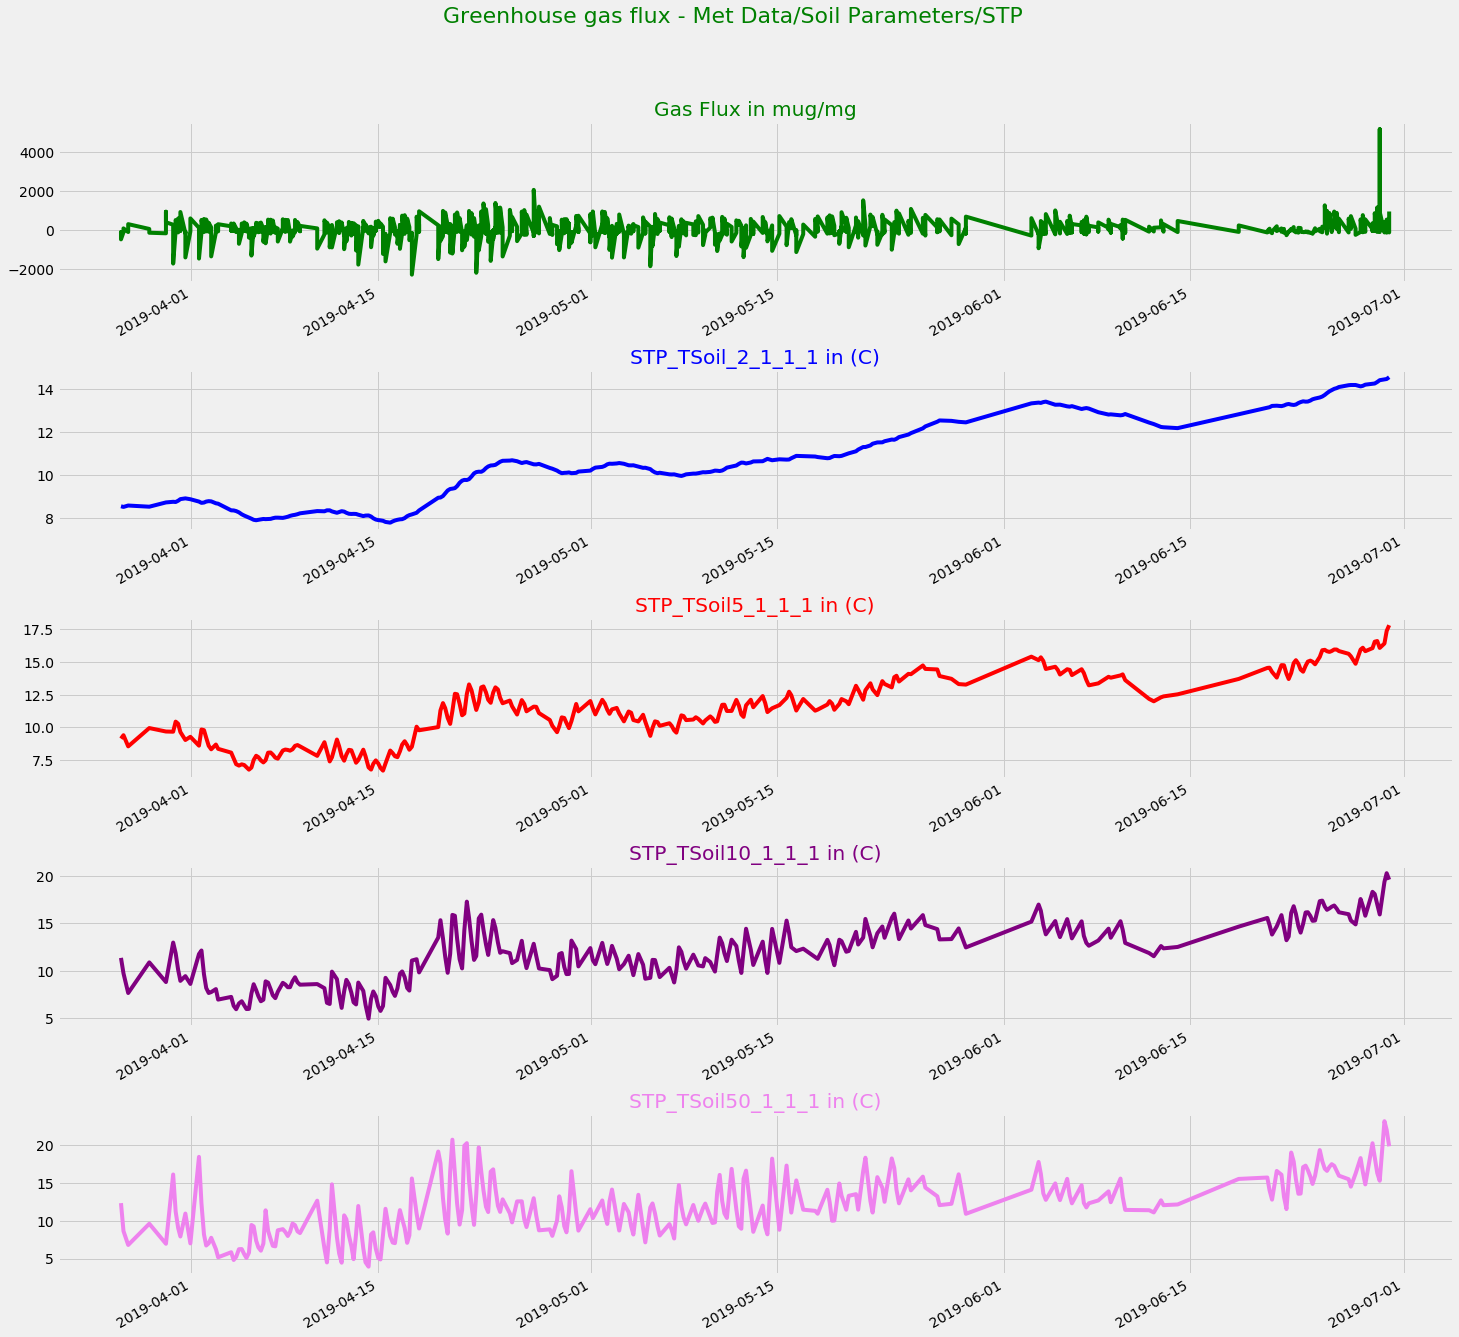

In [36]:
#Plot the merged dataframe   - Vertical Plot -  Soil Parameters (STP)

#Plot the figures VERTICALLY
plt.rcParams["figure.figsize"] = (25, 20)
fig, axs = plt.subplots(5)
fig.suptitle('Greenhouse gas flux - Met Data/Soil Parameters/STP', color = 'green',  size=22)
fig.tight_layout(pad=7.0)

axs[0].plot(plot1_metdata_slice3_1.index, plot1_metdata_slice3_1['Flux'], color = 'green')  #, edgecolor = 'darkblue'
axs[0].set_title('Gas Flux in mug/mg', color = 'green')
#axs[0].set_xticklabels(plot1_metdata_slice3_1.index, rotation=30, ha='right', color = 'green')

unit = metdata_unit.at['STP_TSoil_2_1_1_1', 'metUnit']
axs[1].plot(plot1_metdata_slice3_1.index, plot1_metdata_slice3_1['STP_TSoil_2_1_1_1'],  color = 'blue')
axs[1].set_title('STP_TSoil_2_1_1_1'+' in ('+unit+')', color = 'blue')
#axs[1].set_xticklabels(plot1_metdata_slice3_1.index, rotation=30, ha='right', color = 'blue')

unit = metdata_unit.at['STP_TSoil5_1_1_1', 'metUnit']
axs[2].plot(plot1_metdata_slice3_1.index, plot1_metdata_slice3_1['STP_TSoil5_1_1_1'],  color = 'red')
axs[2].set_title('STP_TSoil5_1_1_1'+' in ('+unit+')', color = 'red')
#axs[2].set_xticklabels(plot1_metdata_slice3_1.index, rotation=30, ha='right', color = 'red')

unit = metdata_unit.at['STP_TSoil10_1_1_1', 'metUnit']
axs[3].plot(plot1_metdata_slice3_1.index, plot1_metdata_slice3_1['STP_TSoil10_1_1_1'],  color = 'purple')
axs[3].set_title('STP_TSoil10_1_1_1'+' in ('+unit+')', color = 'purple')
#axs[3].set_xticklabels(plot1_metdata_slice3_1.index, rotation=30, ha='right', color = 'purple')

unit = metdata_unit.at['STP_TSoil50_1_1_1', 'metUnit']
axs[4].plot(plot1_metdata_slice3_1.index, plot1_metdata_slice3_1['STP_TSoil50_1_1_1'],  color = 'violet')
axs[4].set_title('STP_TSoil50_1_1_1'+' in ('+unit+')', color = 'violet')
#axs[4].set_xticklabels(plot1_metdata_slice3_1.index, rotation=30, ha='right', color = 'violet')

plt.setp(axs[0].get_xticklabels() + axs[1].get_xticklabels() + axs[2].get_xticklabels() +
         axs[3].get_xticklabels() + axs[4].get_xticklabels(), rotation=30, ha='right')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.55)

#Save boxplot as a file
#output file name
output_file_name = "Plot1/MetData_SoilParams_STP_Plot1_gasflux_lineplot_.png" 
plot_file_name = plot_file_path + output_file_name

# save as png
plt.savefig(plot_file_name, dpi=50, bbox_inches='tight')

plt.show()

In [37]:
#Separate the dataframe by greenhouse gas - and then plot (4 vertical plots - 3 gases + 1 met data)

plot1_metdata_slice3_1_N2Odry = plot1_metdata_slice3_1[plot1_metdata_slice3_1['ghg'] == "N2O_dry"]

plot1_metdata_slice3_1_CH4dry = plot1_metdata_slice3_1[plot1_metdata_slice3_1['ghg'] == "CH4_dry"]

plot1_metdata_slice3_1_CO2dry = plot1_metdata_slice3_1[plot1_metdata_slice3_1['ghg'] == "CO2_dry"]

plot1_metdata_slice3_1_N2Odry

,Plot_ID,Flux,ghg,flux_unit,STP_TSoil_2_1_1_1,STP_TSoil5_1_1_1,STP_TSoil10_1_1_1,STP_TSoil20_1_1_1,STP_TSoil50_1_1_1
TIMESTAMP_1_rounded,,,,,,,,,
2019-03-26 17:30:00,1,-144.0262,N2O_dry,mug,8.53,9.12,11.335,12.255,12.32
2019-03-26 22:00:00,1,-102.3469,N2O_dry,mug,8.5,9.38,9.705,9.295,8.625
2019-03-27 06:30:00,1,-93.0909,N2O_dry,mug,8.565,8.525,7.627,7.129,6.79
2019-03-28 20:30:00,1,63.8219,N2O_dry,mug,8.51,9.93,10.86,10.45,9.595
2019-03-30 02:30:00,1,-157.9453,N2O_dry,mug,8.71,9.665,8.785,7.873,6.951
...,...,...,...,...,...,...,...,...,...
2019-06-29 00:30:00,1,-68.7106,N2O_dry,mug,14.35,16.61,16.99,16.695,16.31
2019-06-29 05:00:00,1,-96.2937,N2O_dry,mug,14.435,16.08,15.92,15.59,15.275
2019-06-29 13:30:00,1,-97.1944,N2O_dry,mug,14.47,16.42,19.36,21.425,23.15


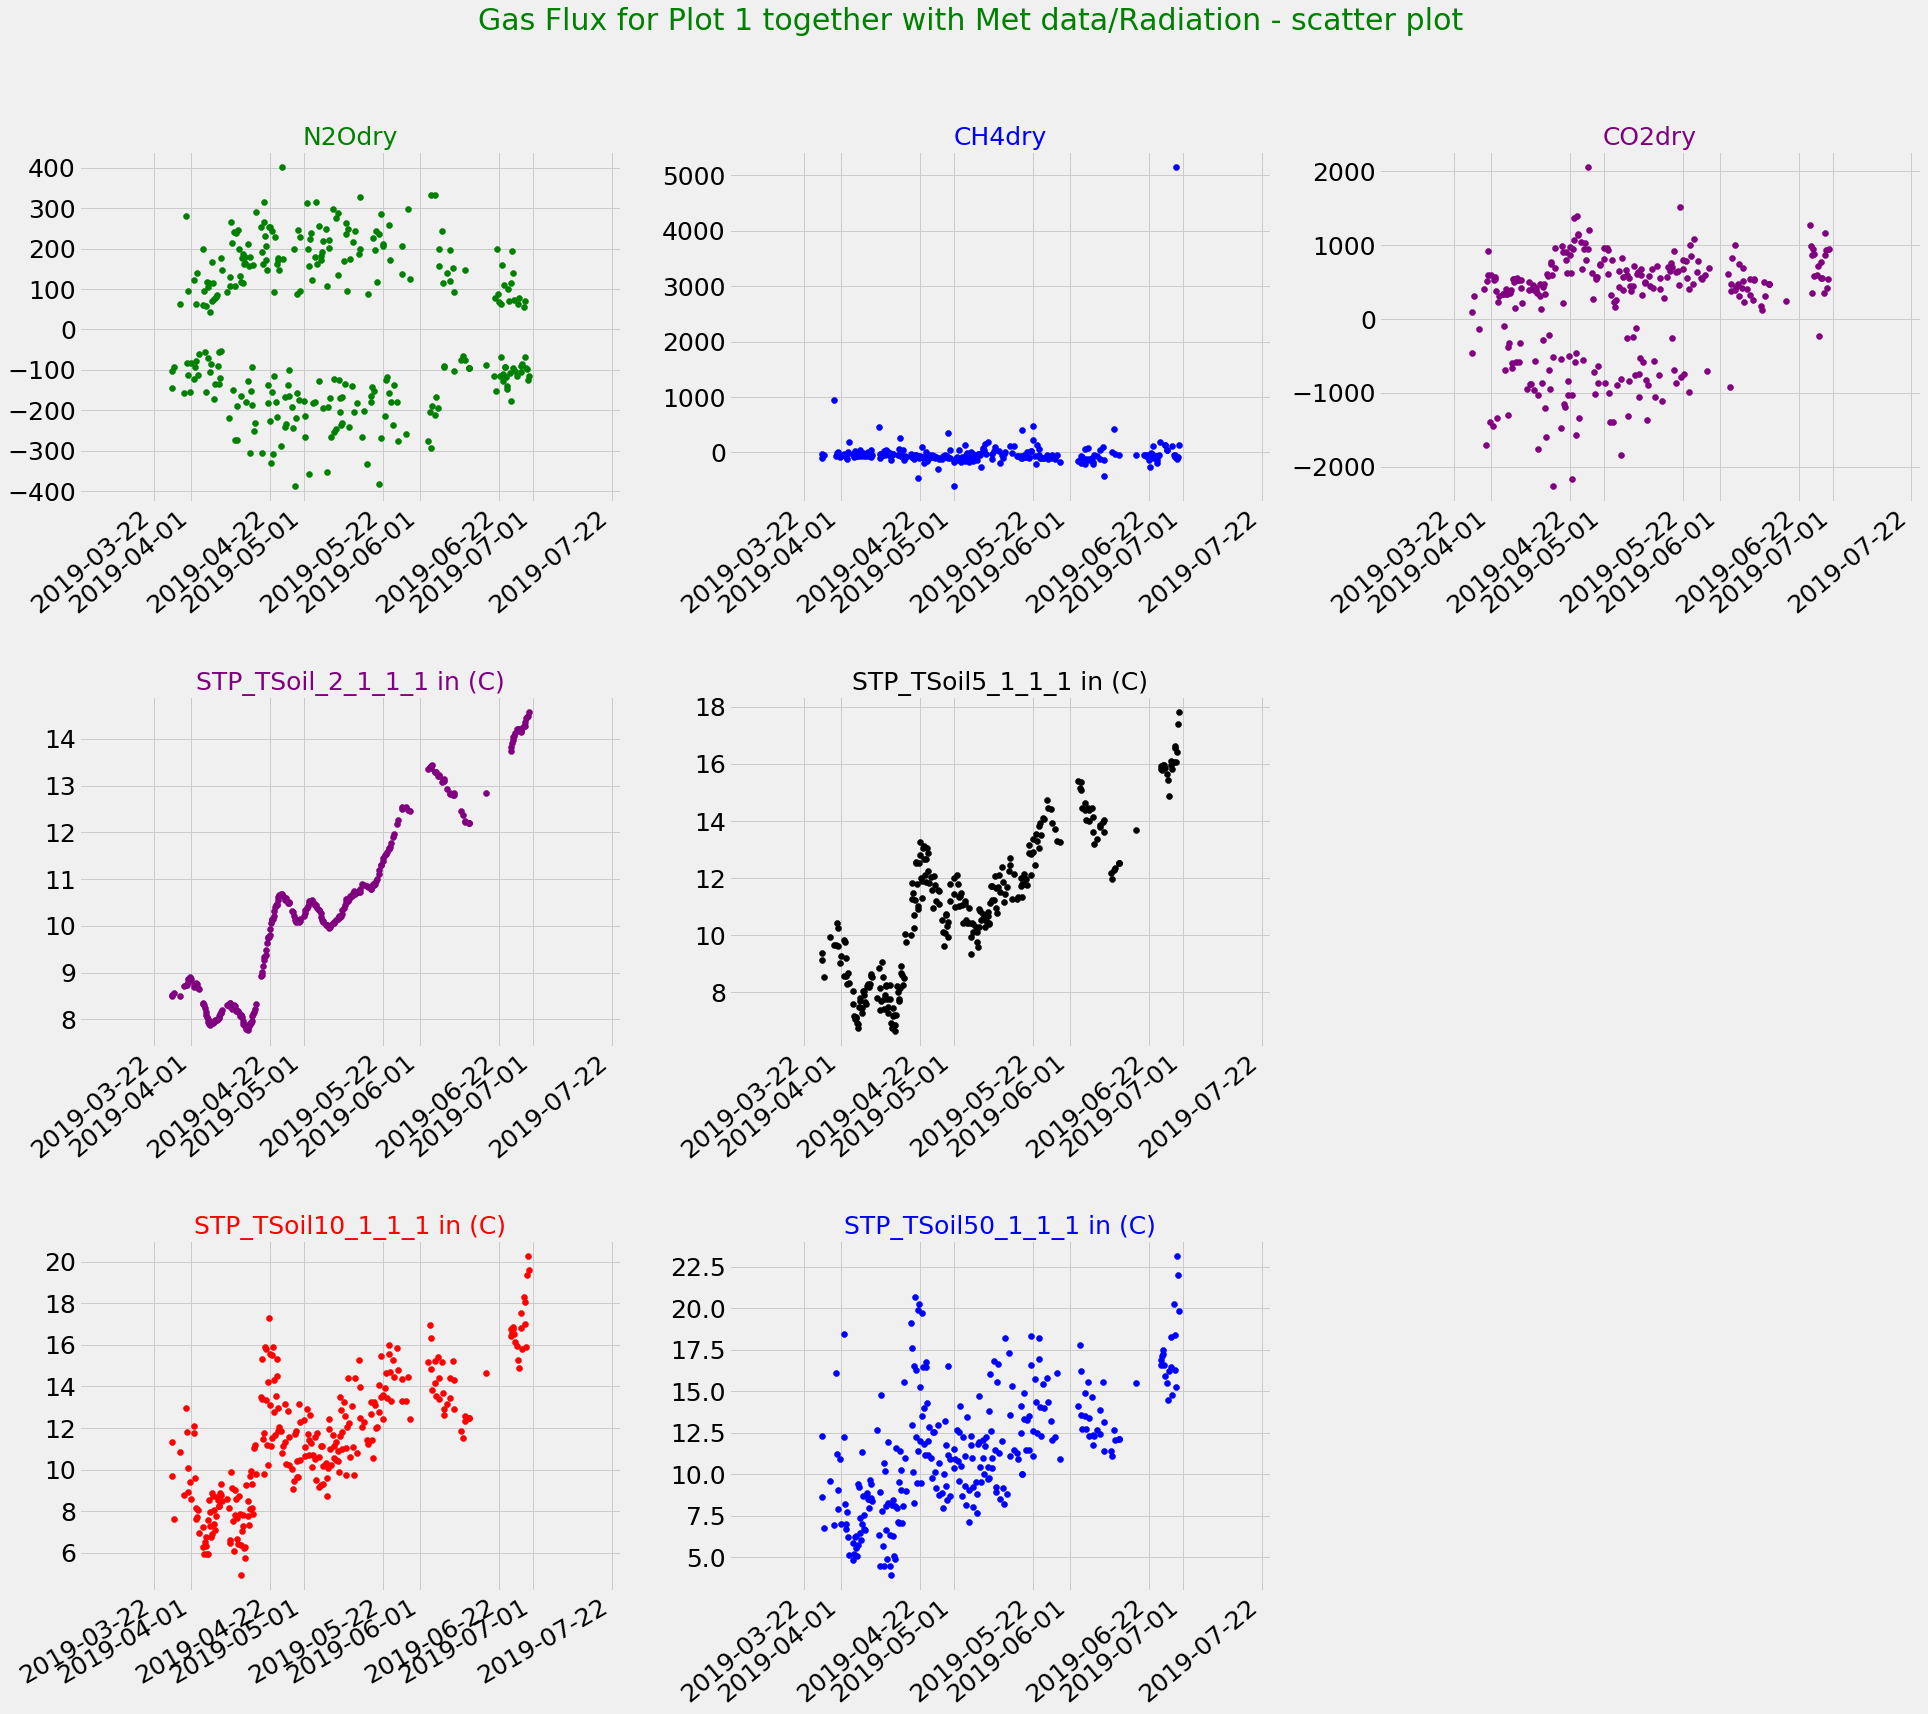

In [38]:
#Plot - Soil Parameters (STP)

#2. plot the different data frames
#fig,ax = plt.subplots()
plt.figure(figsize=(33,25))   #25,14
plt.suptitle('Gas Flux for Plot 1 together with Met data/Radiation - scatter plot', color='green', size=30)

#import matplotlib.gridspec as gridspec
# set up subplot grid
#gridspec.GridSpec(3,3)
#plt.subplot2grid((3,3), (0,0), colspan=4, rowspan=5)
#plt.locator_params(axis='x', nbins=5)
#plt.locator_params(axis='y', nbins=5)

plt.subplot(331)
plt.xticks(rotation=40, ha='right', fontsize=25)
plt.yticks(fontsize=25)
plt.title('N2Odry', color='green', fontsize=25)
plt.scatter(plot1_metdata_slice3_1_N2Odry.index, plot1_metdata_slice3_1_N2Odry['Flux'], color='green')

plt.subplot(332)
plt.xticks(rotation=40, ha='right', fontsize=25)
plt.yticks(fontsize=25)
plt.title('CH4dry', color='blue', fontsize=25)
plt.scatter(plot1_metdata_slice3_1_CH4dry.index, plot1_metdata_slice3_1_CH4dry['Flux'], color='blue')

plt.subplot(333)
plt.xticks(rotation=40, ha='right', fontsize=25)
plt.yticks(fontsize=25)
plt.title('CO2dry', color='purple', fontsize=25)
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['Flux'], color='purple')

plt.subplot(334)
unit = metdata_unit.at['STP_TSoil_2_1_1_1', 'metUnit']
plt.xticks(rotation=40, ha='right', fontsize=25)
plt.yticks(fontsize=25)
plt.title('STP_TSoil_2_1_1_1'+' in ('+unit+')', color='purple', fontsize=25)
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil_2_1_1_1'], color='purple')

plt.subplot(335)
unit = metdata_unit.at['STP_TSoil5_1_1_1', 'metUnit']
plt.xticks(rotation=40, ha='right', fontsize=25)
plt.yticks(fontsize=25)
plt.title('STP_TSoil5_1_1_1'+' in ('+unit+')', color='black', fontsize=25)
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil5_1_1_1'], color='black')

plt.subplot(337)
unit = metdata_unit.at['STP_TSoil10_1_1_1', 'metUnit']
plt.xticks(rotation=30, ha='right', fontsize=25)
plt.yticks(fontsize=25)
plt.title('STP_TSoil10_1_1_1'+' in ('+unit+')', color='red', fontsize=25)
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil10_1_1_1'], color='red')

plt.subplot(338)
unit = metdata_unit.at['STP_TSoil50_1_1_1', 'metUnit']
plt.xticks(rotation=40, ha='right', fontsize=25)
plt.yticks(fontsize=25)
plt.title('STP_TSoil50_1_1_1'+' in ('+unit+')', color='blue', fontsize=25)
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil50_1_1_1'], color='blue')

plt.tight_layout()

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.55)

#Save boxplot as a file
#output file name
output_file_name = "Plot1/MetData_SoilParams_STP_Plot1_gasflux_3gases_v1.png" 
plot_file_name = plot_file_path + output_file_name

# save as png
plt.savefig(plot_file_name, dpi=50, bbox_inches='tight')
plt.show()

In [39]:
# Create two subplots and unpack the output array immediately  - Soil Parameters (STP) - NOT WORKING
#f, ((ax1, ax2, ax3),(ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharey=True, figsize=(36,30))
#f.tight_layout(pad=7.0)

#ax1.scatter(plot1_metdata_slice3_1_N2Odry.index, plot1_metdata_slice3_1_N2Odry['Flux'], color='green')
#ax1.set_title('N2Odry', color='green', fontsize=30)
#ax1.set_xticklabels(plot1_metdata_slice3_1_N2Odry.index, rotation=30, ha='right', fontsize=25)
##ax1.set_yticklabels(plot1_metdata_slice2_N2Odry['Flux'], fontsize=25)
#ax1.set_ylim(-2000, 1000)

#ax2.scatter(plot1_metdata_slice3_1_CH4dry.index, plot1_metdata_slice3_1_CH4dry['Flux'], color='blue')
#ax2.set_title('CH4dry', color='blue', fontsize=30)
#ax2.set_xticklabels(plot1_metdata_slice3_1_CH4dry.index, rotation=30, ha='right',  fontsize=25)

#ax3.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['Flux'], color='purple')
#ax3.set_title('CO2dry', color='purple', fontsize=30)
#ax3.set_xticklabels(plot1_metdata_slice3_1_CO2dry.index, rotation=30, ha='right', fontsize=25)

#unit = metdata_unit.at['STP_TSoil_2_1_1_1', 'metUnit']
#ax4.plot(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil_2_1_1_1'], color='indigo')
#ax4.set_title('STP_TSoil_2_1_1_1'+' in ('+unit+')', color='indigo', fontsize=30)
#ax4.set_xticklabels(plot1_metdata_slice3_1_CO2dry.index, rotation=30, ha='right', fontsize=25)

#unit = metdata_unit.at['STP_TSoil5_1_1_1', 'metUnit']
#ax5.plot(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil5_1_1_1'], color='black')
#ax5.set_title('STP_TSoil5_1_1_1'+' in ('+unit+')', color='black', fontsize=30)
#ax5.set_xticklabels(plot1_metdata_slice3_1_CO2dry.index, rotation=30, ha='right', fontsize=25)

#unit = metdata_unit.at['STP_TSoil10_1_1_1', 'metUnit']
#ax7.plot(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil10_1_1_1'], color='red')
#ax7.set_title('STP_TSoil10_1_1_1'+' in ('+unit+')', color='red', fontsize=30)
#ax7.set_xticklabels(plot1_metdata_slice3_1_CO2dry.index, rotation=30, ha='right', fontsize=25)

#unit = metdata_unit.at['STP_TSoil50_1_1_1', 'metUnit']
#ax8.plot(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil50_1_1_1'], color='red')
#ax8.set_title('STP_TSoil50_1_1_1'+' in ('+unit+')', color='red', fontsize=30)
#ax8.set_xticklabels(plot1_metdata_slice3_1_CO2dry.index, rotation=30, ha='right', fontsize=25)

#plt.tight_layout()

#Save boxplot as a file
#output file name
#output_file_name = "Plot1/MetData_SoilParams_STP_Plot1_gasflux-3gases-v2.png" 
#plot_file_name   = plot_file_path + output_file_name

# save as png
#plt.savefig(plot_file_name, dpi=50, bbox_inches='tight')

#plt.show()

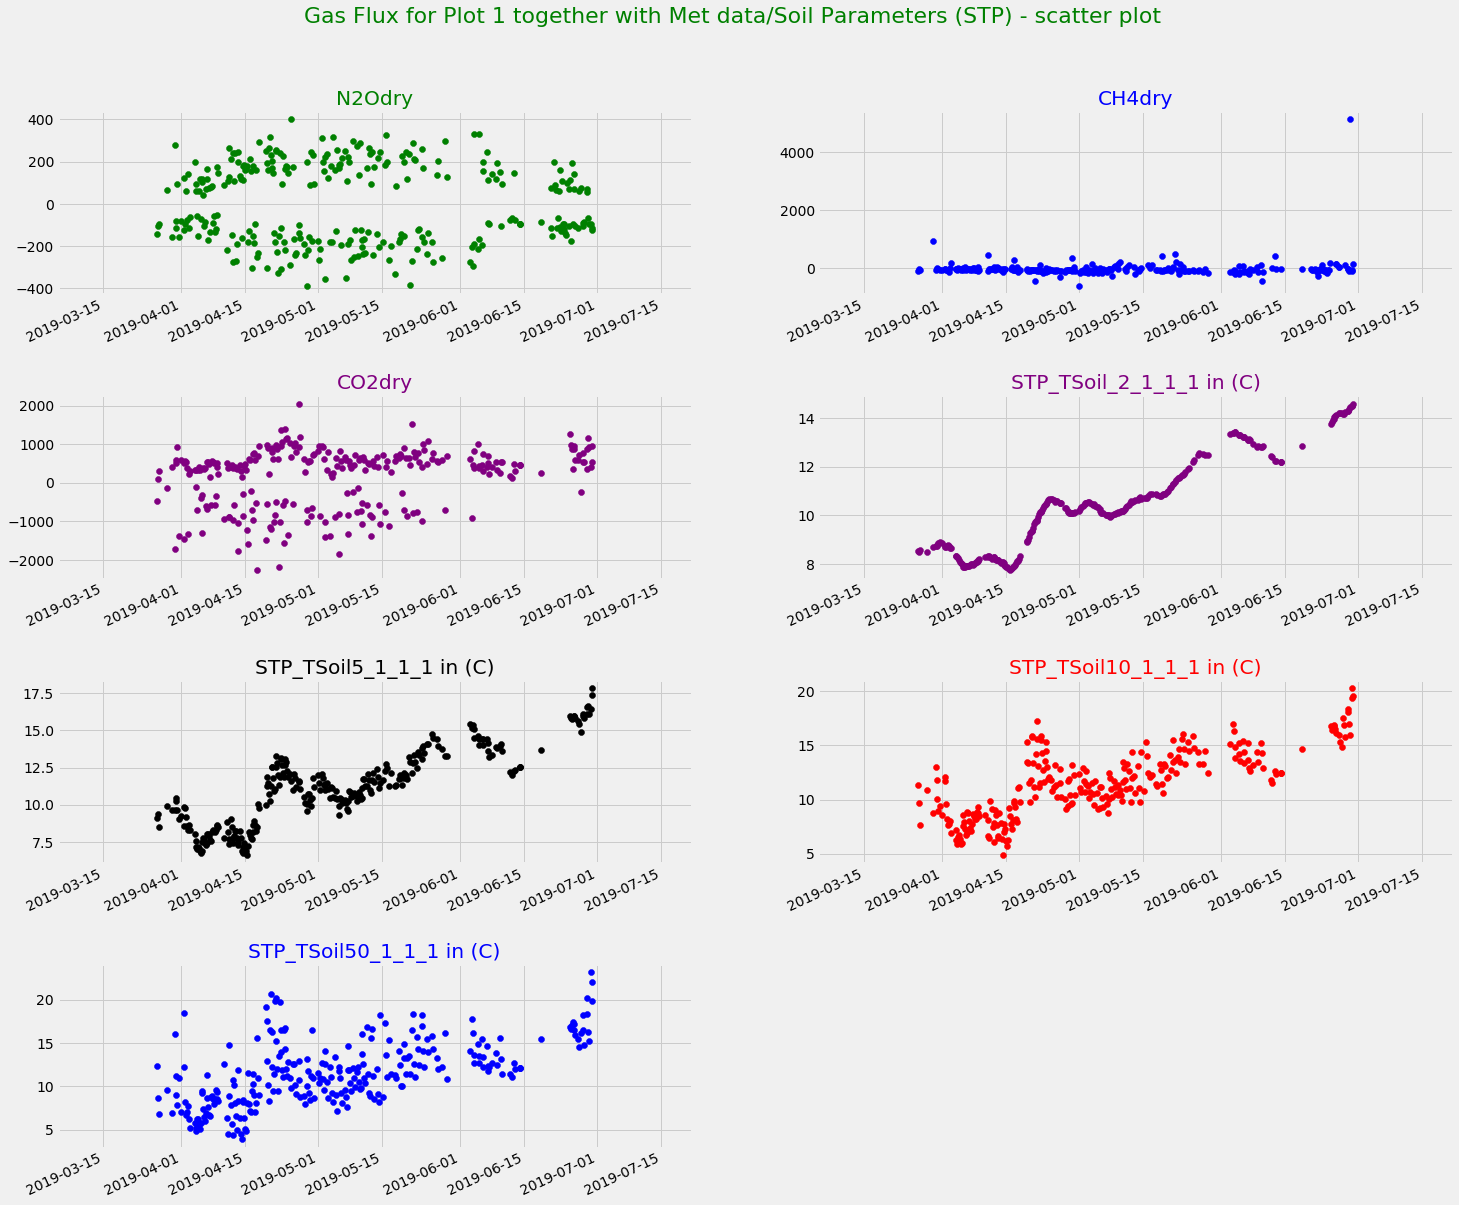

In [40]:
#2. plot the different data frames    - Soil Parameters (STP)
#fig,ax = plt.subplots()
plt.figure(figsize=(25,18))
plt.suptitle('Gas Flux for Plot 1 together with Met data/Soil Parameters (STP) - scatter plot', color='green',  fontsize=22) #, y=1.12
plt.tight_layout(pad=3.0)

plt.subplot(421)
plt.xticks(rotation=25, ha='right')
plt.title('N2Odry', color='green')
plt.scatter(plot1_metdata_slice3_1_N2Odry.index, plot1_metdata_slice3_1_N2Odry['Flux'], color='green')

plt.subplot(422)
plt.xticks(rotation=25, ha='right')
plt.title('CH4dry', color='blue')
plt.scatter(plot1_metdata_slice3_1_CH4dry.index, plot1_metdata_slice3_1_CH4dry['Flux'], color='blue')

plt.subplot(423)
plt.xticks(rotation=25, ha='right')
plt.title('CO2dry', color='purple')
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['Flux'], color='purple')

plt.subplot(424)
unit = metdata_unit.at['STP_TSoil_2_1_1_1', 'metUnit']
plt.xticks(rotation=25, ha='right')
plt.title('STP_TSoil_2_1_1_1'+' in ('+unit+')', color='purple')
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil_2_1_1_1'], color='purple')

plt.subplot(425)
unit = metdata_unit.at['STP_TSoil5_1_1_1', 'metUnit']
plt.xticks(rotation=25, ha='right')
plt.title('STP_TSoil5_1_1_1'+' in ('+unit+')', color='black')
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil5_1_1_1'], color='black')

plt.subplot(426)
unit = metdata_unit.at['STP_TSoil10_1_1_1', 'metUnit']
plt.xticks(rotation=25, ha='right')
plt.title('STP_TSoil10_1_1_1'+' in ('+unit+')', color='red')
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil10_1_1_1'], color='red')

plt.subplot(427)
unit = metdata_unit.at['STP_TSoil50_1_1_1', 'metUnit']
plt.xticks(rotation=25, ha='right')
plt.title('STP_TSoil50_1_1_1'+' in ('+unit+')', color='blue')
plt.scatter(plot1_metdata_slice3_1_CO2dry.index, plot1_metdata_slice3_1_CO2dry['STP_TSoil50_1_1_1'], color='blue')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.55)

#Save boxplot as a file
#output file name
output_file_name = "Plot1/MetData_AirParams_Plot1_gasflux_3gases_v2.png" 
plot_file_name = plot_file_path + output_file_name

# save as png
plt.savefig(plot_file_name, dpi=50, bbox_inches='tight')

plt.show()